In [68]:
from tracemalloc import stop
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
sys.path.insert(1, "D:/AppProgPython/appprog/Lab4")
from df_functions import make_dataframe
from preprocess import preprocess_text

In [69]:
def visualization(epochs, train_losses, valid_losses, train_accuracy, valid_accuracy, batch_size, lr):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (lr={lr}, batch_size={batch_size})')
    plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (lr={lr}, batch_size={batch_size})')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (lr={lr}, batch_size={batch_size})')
    plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (lr={lr}, batch_size={batch_size})')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.tight_layout()
    plt.show()

In [70]:
def change_label(data:pd.DataFrame, rate: int) -> pd.DataFrame:
    """Changes labels in the dataframe"""
    data.dropna(inplace=True)
    labels = lambda x: 1 if x == rate or x == rate+1 else 0
    data['label'] = data['Рейтинг'].apply(labels)
    return data

In [71]:
def load_data(file_path: str) -> pd.DataFrame:
    """Loads data for csv file and preprocesses texts for vectorizing"""
    data = make_dataframe(file_path)
    data = preprocess_text(data)
    return data

In [72]:
def vectorizer(df: pd.DataFrame):
    """Vectorizes dataframe"""
    cv = CountVectorizer(max_features=1000, stop_words=stopwords.words('russian'))
    sparse_matrix = cv.fit_transform(df["Текст отзыва"]).toarray()
    return sparse_matrix

In [73]:
def split_data(all_data, df:pd.DataFrame):
    """Splits data into train and test samples"""
    text = np.array(df["label"])
    x_train, x_test, y_train, y_test = train_test_split(all_data, text, test_size=0.5, random_state=42, shuffle=True)
    return x_train, x_test, y_train, y_test


Loading dataset

In [74]:
df = load_data('D:/AppProgPython/appprog/csv/final1.csv')


Changing the label due to using the LogisticRegression

In [75]:
changed = change_label(df, 4)
vec = vectorizer(changed)
df.to_csv("D:/AppProgPython/appprog/csv/prepro.csv")
df.dropna(inplace =True)
df

,Абсолютный путь,Рейтинг,Текст отзыва,Количество слов,label
0,D:\AppProgPython\appprog\dataset\1\0000.txt,1,хотеть поделиться история взаимодействие альфа...,639,0
1,D:\AppProgPython\appprog\dataset\1\0001.txt,1,оказываться хотя сотрудник банк неоднократно п...,156,0
2,D:\AppProgPython\appprog\dataset\1\0002.txt,1,приходить вознаграждение оказываться хотя сотр...,160,0
3,D:\AppProgPython\appprog\dataset\1\0003.txt,1,написать чат бот работать ужасно банк написато...,142,0
4,D:\AppProgPython\appprog\dataset\1\0004.txt,1,работать ужасно банк написато невозможно сотру...,137,0
...,...,...,...,...,...
2148,D:\AppProgPython\appprog\dataset\5\0495.txt,5,30 сентябрь решать становиться клиент альфа-ба...,74,1
2149,D:\AppProgPython\appprog\dataset\5\0496.txt,5,1 октябрь обращаться контактный центр альфа ба...,69,1
2150,D:\AppProgPython\appprog\dataset\5\0497.txt,5,добрый день пользователь дебетовый карта альфа...,228,1
2151,D:\AppProgPython\appprog\dataset\5\0498.txt,5,добрый день приходить уведомление мобильный пр...,194,1


Class LogisticRegression (our model)

In [76]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(1000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
x_train, x_tmp, y_train, y_tmp = split_data(vec, changed)
x_test, x_valid, y_test, y_valid = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42, shuffle=True)

In [77]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()

Creating datasets for model

In [78]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

Learning rates and batch sizes

In [79]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 50
loss_values = []
models = []

Training loop

Learning rate: 0.0001
Batch size: 32
Epoch 1/50, Training Loss: 0.6855, Training Accuracy: 0.5511, Validation Loss: 0.6673, Validation Accuracy: 0.7143
Epoch 2/50, Training Loss: 0.6520, Training Accuracy: 0.7677, Validation Loss: 0.6306, Validation Accuracy: 0.7718
Epoch 3/50, Training Loss: 0.6143, Training Accuracy: 0.8104, Validation Loss: 0.5948, Validation Accuracy: 0.8015
Epoch 4/50, Training Loss: 0.5721, Training Accuracy: 0.8448, Validation Loss: 0.5563, Validation Accuracy: 0.8256
Epoch 5/50, Training Loss: 0.5255, Training Accuracy: 0.8838, Validation Loss: 0.5154, Validation Accuracy: 0.8460
Epoch 6/50, Training Loss: 0.4740, Training Accuracy: 0.8922, Validation Loss: 0.4742, Validation Accuracy: 0.8627
Epoch 7/50, Training Loss: 0.4249, Training Accuracy: 0.9006, Validation Loss: 0.4404, Validation Accuracy: 0.8627
Epoch 8/50, Training Loss: 0.3804, Training Accuracy: 0.9080, Validation Loss: 0.4120, Validation Accuracy: 0.8664
Epoch 9/50, Training Loss: 0.3407, Training

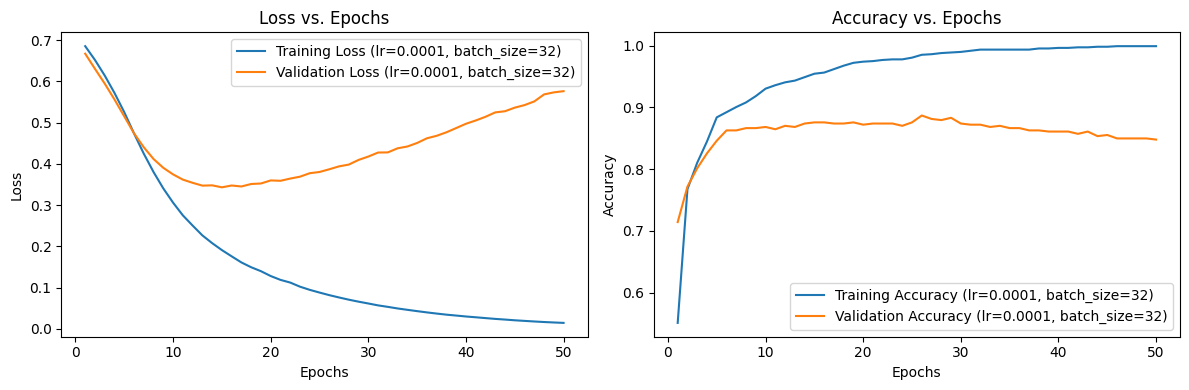

Learning rate: 0.0001
Batch size: 64
Epoch 1/50, Training Loss: 0.6875, Training Accuracy: 0.5390, Validation Loss: 0.6735, Validation Accuracy: 0.6438
Epoch 2/50, Training Loss: 0.6655, Training Accuracy: 0.6952, Validation Loss: 0.6474, Validation Accuracy: 0.7458
Epoch 3/50, Training Loss: 0.6412, Training Accuracy: 0.7268, Validation Loss: 0.6254, Validation Accuracy: 0.7403
Epoch 4/50, Training Loss: 0.6183, Training Accuracy: 0.7444, Validation Loss: 0.6025, Validation Accuracy: 0.7217
Epoch 5/50, Training Loss: 0.5964, Training Accuracy: 0.7639, Validation Loss: 0.5823, Validation Accuracy: 0.7440
Epoch 6/50, Training Loss: 0.5753, Training Accuracy: 0.7928, Validation Loss: 0.5686, Validation Accuracy: 0.7514
Epoch 7/50, Training Loss: 0.5556, Training Accuracy: 0.8113, Validation Loss: 0.5483, Validation Accuracy: 0.7681
Epoch 8/50, Training Loss: 0.5390, Training Accuracy: 0.8346, Validation Loss: 0.5380, Validation Accuracy: 0.7811
Epoch 9/50, Training Loss: 0.5208, Training

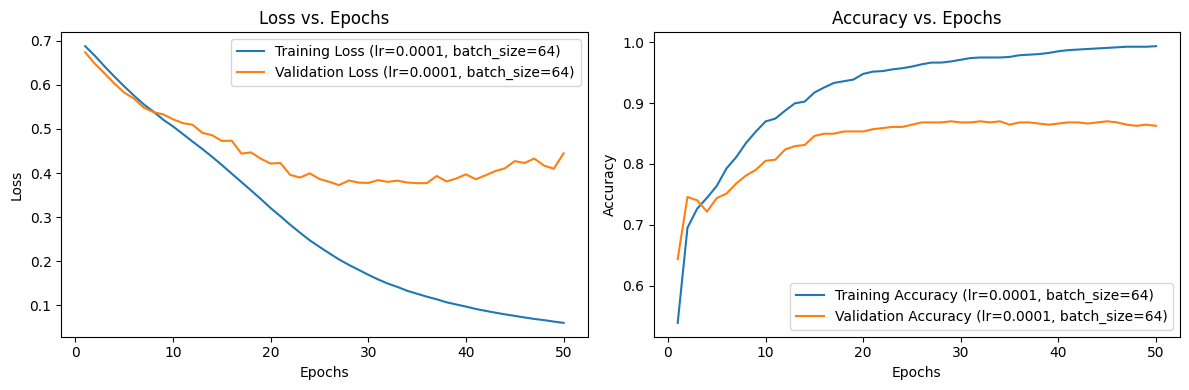

Learning rate: 0.0001
Batch size: 128
Epoch 1/50, Training Loss: 0.6997, Training Accuracy: 0.4786, Validation Loss: 0.6994, Validation Accuracy: 0.4675
Epoch 2/50, Training Loss: 0.6923, Training Accuracy: 0.4814, Validation Loss: 0.6892, Validation Accuracy: 0.4935
Epoch 3/50, Training Loss: 0.6861, Training Accuracy: 0.5121, Validation Loss: 0.6815, Validation Accuracy: 0.5696
Epoch 4/50, Training Loss: 0.6751, Training Accuracy: 0.5929, Validation Loss: 0.6688, Validation Accuracy: 0.6456
Epoch 5/50, Training Loss: 0.6644, Training Accuracy: 0.6849, Validation Loss: 0.6588, Validation Accuracy: 0.7310
Epoch 6/50, Training Loss: 0.6525, Training Accuracy: 0.7574, Validation Loss: 0.6464, Validation Accuracy: 0.7774
Epoch 7/50, Training Loss: 0.6408, Training Accuracy: 0.7937, Validation Loss: 0.6359, Validation Accuracy: 0.8108
Epoch 8/50, Training Loss: 0.6283, Training Accuracy: 0.8281, Validation Loss: 0.6241, Validation Accuracy: 0.8312
Epoch 9/50, Training Loss: 0.6162, Trainin

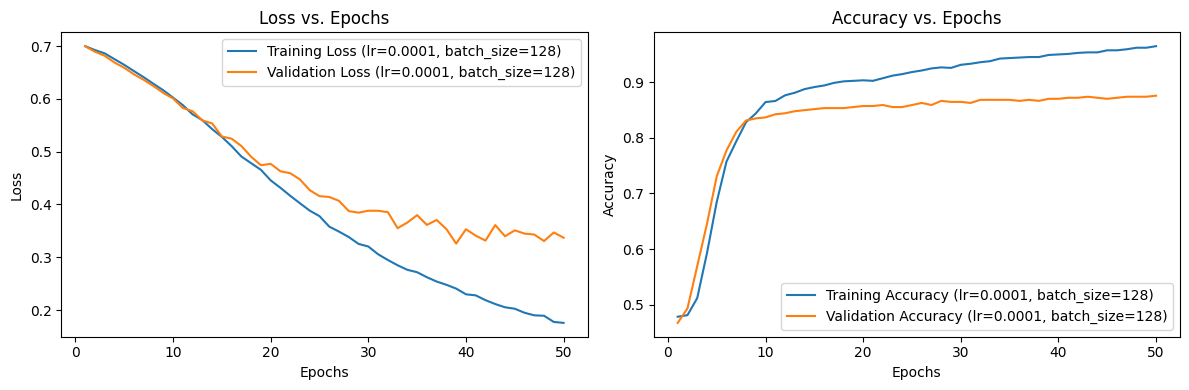

Learning rate: 0.001
Batch size: 32
Epoch 1/50, Training Loss: 0.6048, Training Accuracy: 0.6310, Validation Loss: 0.4633, Validation Accuracy: 0.8497
Epoch 2/50, Training Loss: 0.3133, Training Accuracy: 0.8968, Validation Loss: 0.3526, Validation Accuracy: 0.8738
Epoch 3/50, Training Loss: 0.1661, Training Accuracy: 0.9452, Validation Loss: 0.3756, Validation Accuracy: 0.8738
Epoch 4/50, Training Loss: 0.1025, Training Accuracy: 0.9712, Validation Loss: 0.4245, Validation Accuracy: 0.8646
Epoch 5/50, Training Loss: 0.0602, Training Accuracy: 0.9879, Validation Loss: 0.4801, Validation Accuracy: 0.8627
Epoch 6/50, Training Loss: 0.0356, Training Accuracy: 0.9954, Validation Loss: 0.5590, Validation Accuracy: 0.8479
Epoch 7/50, Training Loss: 0.0217, Training Accuracy: 0.9963, Validation Loss: 0.6390, Validation Accuracy: 0.8479
Epoch 8/50, Training Loss: 0.0130, Training Accuracy: 0.9981, Validation Loss: 0.6940, Validation Accuracy: 0.8404
Epoch 9/50, Training Loss: 0.0079, Training 

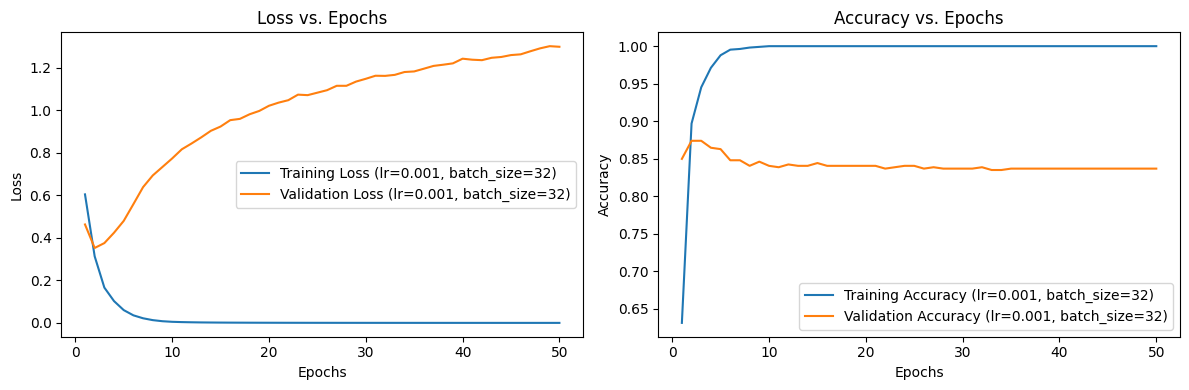

Learning rate: 0.001
Batch size: 64
Epoch 1/50, Training Loss: 0.6160, Training Accuracy: 0.6450, Validation Loss: 0.5410, Validation Accuracy: 0.7607
Epoch 2/50, Training Loss: 0.4623, Training Accuracy: 0.8810, Validation Loss: 0.4514, Validation Accuracy: 0.8553
Epoch 3/50, Training Loss: 0.3193, Training Accuracy: 0.9266, Validation Loss: 0.3945, Validation Accuracy: 0.8627
Epoch 4/50, Training Loss: 0.2002, Training Accuracy: 0.9582, Validation Loss: 0.3945, Validation Accuracy: 0.8627
Epoch 5/50, Training Loss: 0.1272, Training Accuracy: 0.9730, Validation Loss: 0.4246, Validation Accuracy: 0.8590
Epoch 6/50, Training Loss: 0.0888, Training Accuracy: 0.9805, Validation Loss: 0.4410, Validation Accuracy: 0.8590
Epoch 7/50, Training Loss: 0.0612, Training Accuracy: 0.9888, Validation Loss: 0.5446, Validation Accuracy: 0.8516
Epoch 8/50, Training Loss: 0.0453, Training Accuracy: 0.9926, Validation Loss: 0.5861, Validation Accuracy: 0.8571
Epoch 9/50, Training Loss: 0.0334, Training 

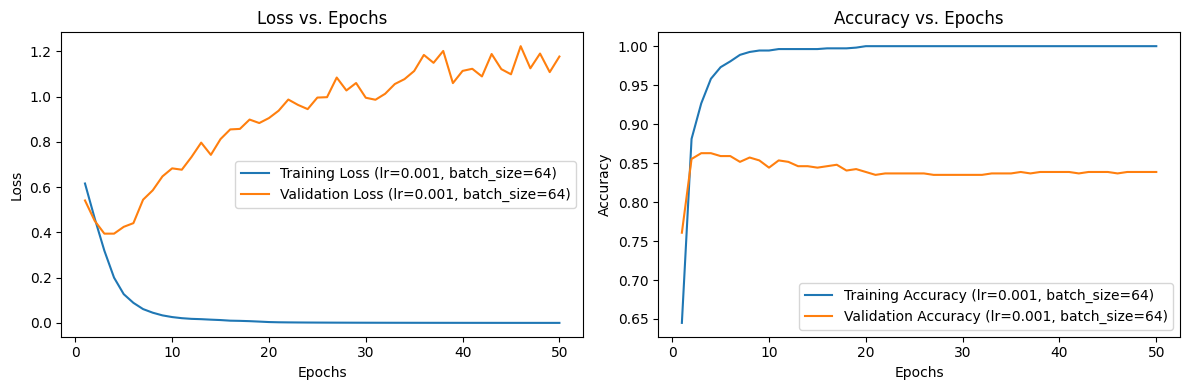

Learning rate: 0.001
Batch size: 128
Epoch 1/50, Training Loss: 0.6648, Training Accuracy: 0.7463, Validation Loss: 0.6095, Validation Accuracy: 0.8163
Epoch 2/50, Training Loss: 0.5462, Training Accuracy: 0.8708, Validation Loss: 0.4827, Validation Accuracy: 0.8516
Epoch 3/50, Training Loss: 0.4085, Training Accuracy: 0.8987, Validation Loss: 0.4019, Validation Accuracy: 0.8571
Epoch 4/50, Training Loss: 0.3008, Training Accuracy: 0.9108, Validation Loss: 0.3719, Validation Accuracy: 0.8534
Epoch 5/50, Training Loss: 0.2286, Training Accuracy: 0.9377, Validation Loss: 0.3484, Validation Accuracy: 0.8720
Epoch 6/50, Training Loss: 0.1762, Training Accuracy: 0.9461, Validation Loss: 0.3367, Validation Accuracy: 0.8757
Epoch 7/50, Training Loss: 0.1257, Training Accuracy: 0.9656, Validation Loss: 0.4218, Validation Accuracy: 0.8776
Epoch 8/50, Training Loss: 0.0999, Training Accuracy: 0.9730, Validation Loss: 0.3516, Validation Accuracy: 0.8776
Epoch 9/50, Training Loss: 0.0759, Training

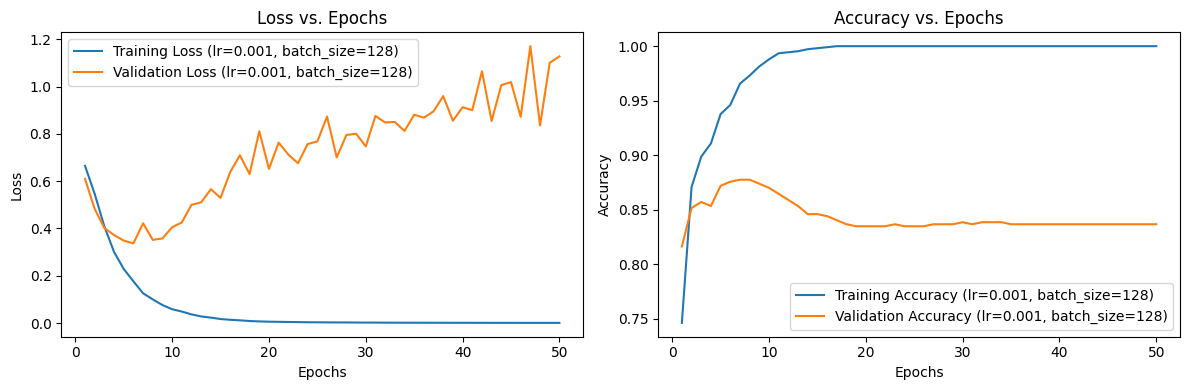

Learning rate: 0.01
Batch size: 32
Epoch 1/50, Training Loss: 0.4426, Training Accuracy: 0.8048, Validation Loss: 0.3878, Validation Accuracy: 0.8646
Epoch 2/50, Training Loss: 0.1667, Training Accuracy: 0.9377, Validation Loss: 0.4575, Validation Accuracy: 0.8516
Epoch 3/50, Training Loss: 0.0700, Training Accuracy: 0.9786, Validation Loss: 0.6706, Validation Accuracy: 0.8182
Epoch 4/50, Training Loss: 0.0355, Training Accuracy: 0.9861, Validation Loss: 0.8813, Validation Accuracy: 0.8534
Epoch 5/50, Training Loss: 0.0056, Training Accuracy: 1.0000, Validation Loss: 1.0865, Validation Accuracy: 0.8516
Epoch 6/50, Training Loss: 0.0017, Training Accuracy: 1.0000, Validation Loss: 1.2685, Validation Accuracy: 0.8497
Epoch 7/50, Training Loss: 0.0007, Training Accuracy: 1.0000, Validation Loss: 1.3798, Validation Accuracy: 0.8479
Epoch 8/50, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Loss: 1.4766, Validation Accuracy: 0.8460
Epoch 9/50, Training Loss: 0.0002, Training A

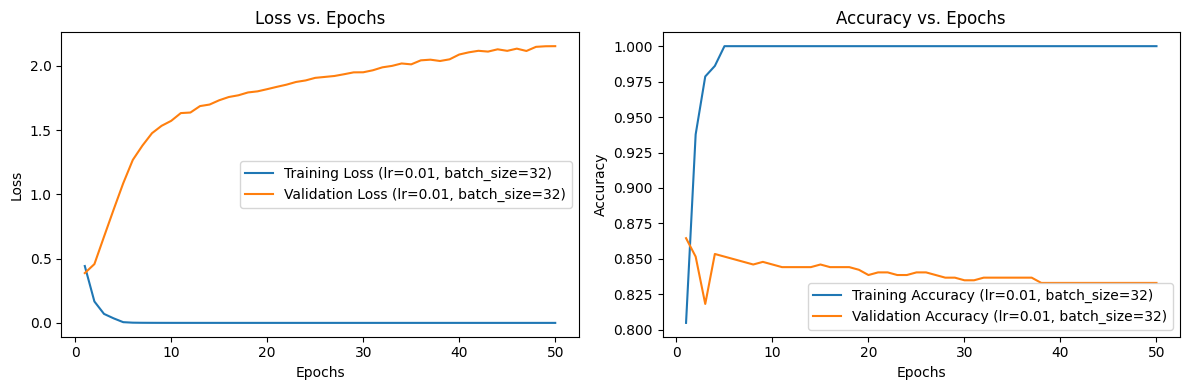

Learning rate: 0.01
Batch size: 64
Epoch 1/50, Training Loss: 0.4743, Training Accuracy: 0.7695, Validation Loss: 0.3331, Validation Accuracy: 0.8701
Epoch 2/50, Training Loss: 0.1834, Training Accuracy: 0.9340, Validation Loss: 0.3873, Validation Accuracy: 0.8590
Epoch 3/50, Training Loss: 0.0820, Training Accuracy: 0.9730, Validation Loss: 0.7004, Validation Accuracy: 0.8553
Epoch 4/50, Training Loss: 0.0336, Training Accuracy: 0.9861, Validation Loss: 0.7647, Validation Accuracy: 0.8590
Epoch 5/50, Training Loss: 0.0103, Training Accuracy: 0.9972, Validation Loss: 0.9047, Validation Accuracy: 0.8590
Epoch 6/50, Training Loss: 0.0038, Training Accuracy: 0.9991, Validation Loss: 1.2613, Validation Accuracy: 0.8534
Epoch 7/50, Training Loss: 0.0014, Training Accuracy: 1.0000, Validation Loss: 1.2993, Validation Accuracy: 0.8590
Epoch 8/50, Training Loss: 0.0007, Training Accuracy: 1.0000, Validation Loss: 1.3702, Validation Accuracy: 0.8534
Epoch 9/50, Training Loss: 0.0003, Training A

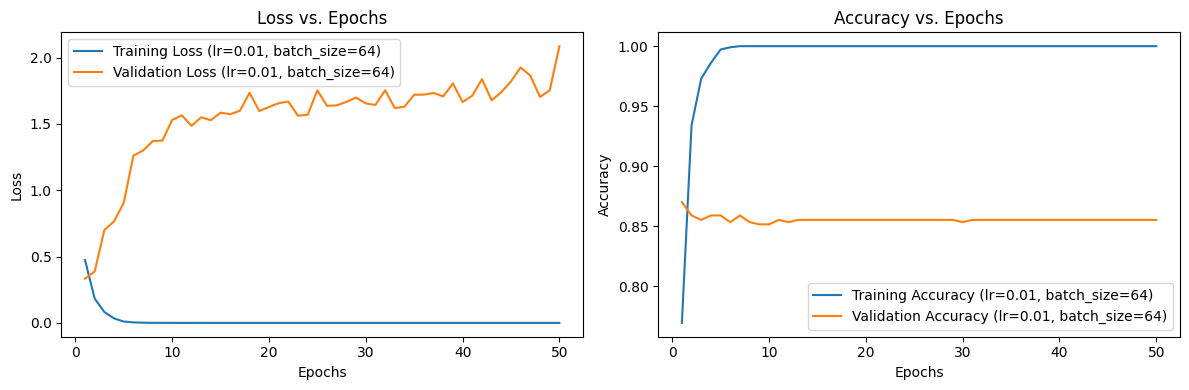

Learning rate: 0.01
Batch size: 128
Epoch 1/50, Training Loss: 0.5461, Training Accuracy: 0.7333, Validation Loss: 0.4549, Validation Accuracy: 0.8683
Epoch 2/50, Training Loss: 0.3017, Training Accuracy: 0.9219, Validation Loss: 0.6062, Validation Accuracy: 0.8609
Epoch 3/50, Training Loss: 0.1254, Training Accuracy: 0.9619, Validation Loss: 0.6697, Validation Accuracy: 0.8442
Epoch 4/50, Training Loss: 0.0809, Training Accuracy: 0.9740, Validation Loss: 0.7460, Validation Accuracy: 0.8367
Epoch 5/50, Training Loss: 0.0788, Training Accuracy: 0.9749, Validation Loss: 1.0109, Validation Accuracy: 0.8534
Epoch 6/50, Training Loss: 0.0758, Training Accuracy: 0.9796, Validation Loss: 1.1682, Validation Accuracy: 0.8404
Epoch 7/50, Training Loss: 0.0389, Training Accuracy: 0.9861, Validation Loss: 1.0087, Validation Accuracy: 0.8460
Epoch 8/50, Training Loss: 0.0238, Training Accuracy: 0.9944, Validation Loss: 0.9455, Validation Accuracy: 0.8386
Epoch 9/50, Training Loss: 0.0121, Training 

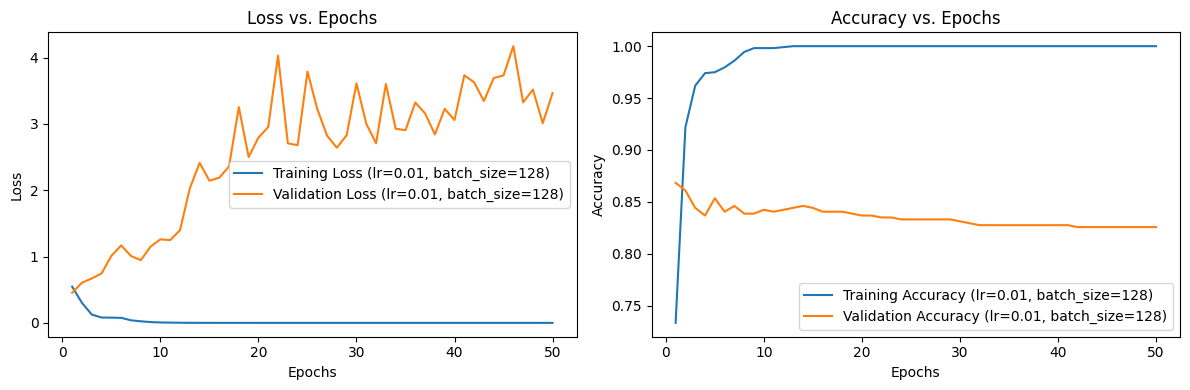

Test Accuracy: 0.8513


In [80]:
for lr in learning_rates:
    for bs in batch_sizes:
        model = LogisticRegression()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)
        
        print(f'Learning rate: {lr}')
        print(f'Batch size: {bs}')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

        # Training loop
        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracy.append(correct_train / total_train)

            # Validation
            model.eval()

            running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(running_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)
                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        visualization(epochs, train_losses, valid_losses, train_accuracy, valid_accuracy, bs, lr)

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')


Repeated initialization of the model with the normal learning rate and batch size

In [97]:
batch_size = 128
lr = 0.0001
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

epochs = 20

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Validation
    model.eval()

    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
        valid_losses.append(running_loss / len(valid_loader))
        valid_accuracy.append(correct_valid / total_valid)
        print(f'Epoch {epoch + 1}/{epochs}, '
            f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
            f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')

Epoch 1/20, Training Loss: 0.7032, Training Accuracy: 0.4870, Validation Loss: 0.6788, Validation Accuracy: 0.4972
Epoch 2/20, Training Loss: 0.6836, Training Accuracy: 0.5260, Validation Loss: 0.6602, Validation Accuracy: 0.5733
Epoch 3/20, Training Loss: 0.6631, Training Accuracy: 0.6004, Validation Loss: 0.6421, Validation Accuracy: 0.6531
Epoch 4/20, Training Loss: 0.6435, Training Accuracy: 0.6664, Validation Loss: 0.6255, Validation Accuracy: 0.7236
Epoch 5/20, Training Loss: 0.6256, Training Accuracy: 0.7277, Validation Loss: 0.6108, Validation Accuracy: 0.7625
Epoch 6/20, Training Loss: 0.6132, Training Accuracy: 0.7472, Validation Loss: 0.5973, Validation Accuracy: 0.7681
Epoch 7/20, Training Loss: 0.5932, Training Accuracy: 0.7760, Validation Loss: 0.5845, Validation Accuracy: 0.7885
Epoch 8/20, Training Loss: 0.5793, Training Accuracy: 0.7928, Validation Loss: 0.5716, Validation Accuracy: 0.7996
Epoch 9/20, Training Loss: 0.5611, Training Accuracy: 0.8086, Validation Loss: 0

Saving the model

In [98]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

creating sample

In [103]:
sample = "единственный банк который показывать мобильный приложение сумма дата платеж \
    сохранение беспроцентный период отражаться платеж "" -  лишь минимальный платеж "
max_words = 1000
cv = CountVectorizer(max_features=max_words, stop_words=stopwords.words('russian'))
sparse_matrix = cv.fit_transform(np.array([sample])).toarray()
if sparse_matrix.shape[1] < 1000:
    sparse_matrix = np.pad(sparse_matrix, ((0, 0), (0, 1000 - sparse_matrix.shape[1])))
sparse_matrix.shape

(1, 1000)

Loading checkpoint of the model

In [104]:
review = Variable(torch.from_numpy(sparse_matrix)).float()
model = LogisticRegression()
load_checkpoint = torch.load('model.pth')
model.load_state_dict(load_checkpoint['model_state_dict'])
optimizer.load_state_dict(load_checkpoint['optimizer_state_dict'])
epoch = load_checkpoint['epoch']

model.eval()

LogisticRegression(
  (linear1): Linear(in_features=1000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=2, bias=True)
)

Predicting class of the sample

In [105]:
with torch.no_grad():
    output = model(review)
    print('output: ', output)


predict = torch.argmax(output).item()

print(f"Предсказанный класс: {predict}")

output:  tensor([[-0.0868, -0.0261]])
Предсказанный класс: 1
